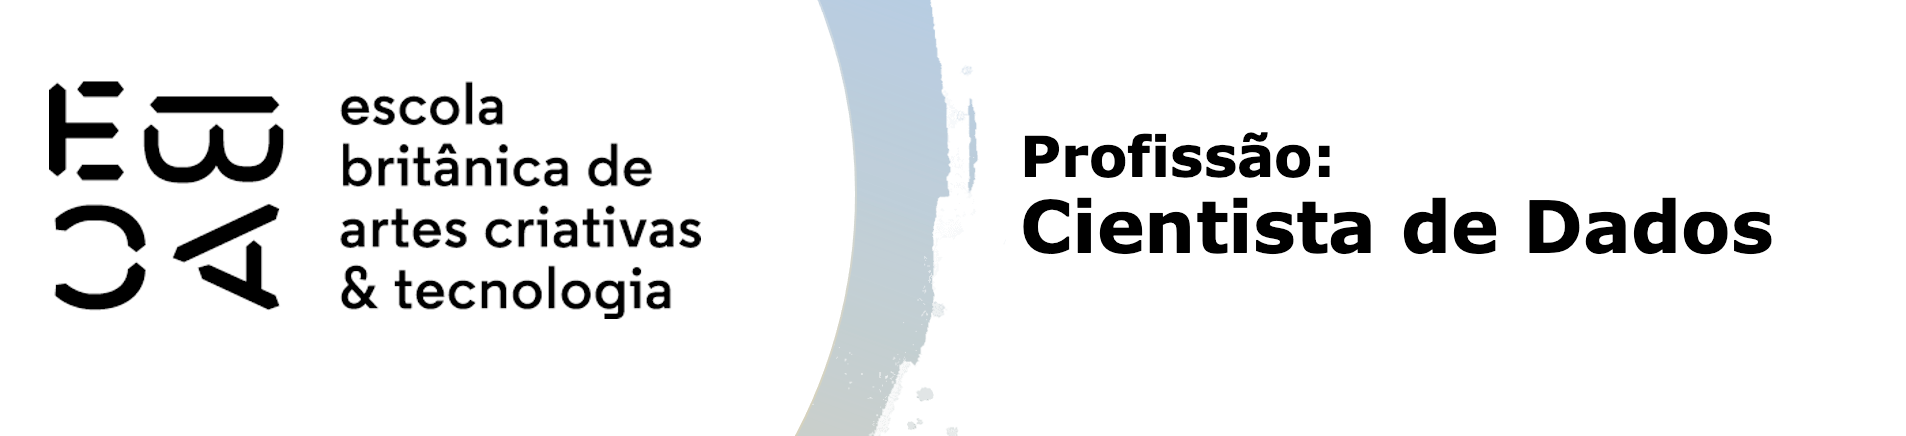

# Tarefa - Agrupamento hierárquico

Neste exercício vamos usar a base [online shoppers purchase intention](https://archive.ics.uci.edu/ml/datasets/Online+Shoppers+Purchasing+Intention+Dataset) de Sakar, C.O., Polat, S.O., Katircioglu, M. et al. Neural Comput & Applic (2018). [Web Link](https://doi.org/10.1007/s00521-018-3523-0).

A base trata de registros de 12.330 sessões de acesso a páginas, cada sessão sendo de um único usuário em um período de 12 meses, para posteriormente estudarmos a relação entre o design da página e o perfil do cliente - "Será que clientes com comportamento de navegação diferentes possuem propensão a compra diferente?" 

Nosso objetivo agora é agrupar as sessões de acesso ao portal considerando o comportamento de acesso e informações da data, como a proximidade a uma data especial, fim de semana e o mês.

|Variavel                |Descrição          | 
|------------------------|:-------------------| 
|Administrative          | Quantidade de acessos em páginas administrativas| 
|Administrative_Duration | Tempo de acesso em páginas administrativas | 
|Informational           | Quantidade de acessos em páginas informativas  | 
|Informational_Duration  | Tempo de acesso em páginas informativas  | 
|ProductRelated          | Quantidade de acessos em páginas de produtos | 
|ProductRelated_Duration | Tempo de acesso em páginas de produtos | 
|BounceRates             | *Percentual de visitantes que entram no site e saem sem acionar outros *requests* durante a sessão  | 
|ExitRates               | * Soma de vezes que a página é visualizada por último em uma sessão dividido pelo total de visualizações | 
|PageValues              | * Representa o valor médio de uma página da Web que um usuário visitou antes de concluir uma transação de comércio eletrônico | 
|SpecialDay              | Indica a proximidade a uma data festiva (dia das mães etc) | 
|Month                   | Mês  | 
|OperatingSystems        | Sistema operacional do visitante | 
|Browser                 | Browser do visitante | 
|Region                  | Região | 
|TrafficType             | Tipo de tráfego                  | 
|VisitorType             | Tipo de visitante: novo ou recorrente | 
|Weekend                 | Indica final de semana | 
|Revenue                 | Indica se houve compra ou não |

\* variávels calculadas pelo google analytics

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler

import scipy.cluster.hierarchy as shc

from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from gower import gower_matrix
import pandas as pd
import seaborn as sns

import numpy as np

from scipy.spatial.distance import pdist, squareform

import matplotlib.pyplot as plt

In [60]:
df = pd.read_csv('online_shoppers_intention.csv')

In [61]:
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [62]:
df.Revenue.value_counts(dropna=False)

False    10422
True      1908
Name: Revenue, dtype: int64

## Análise descritiva

Faça uma análise descritiva das variáveis do escopo.

- Verifique a distribuição dessas variáveis
- Veja se há valores *missing* e caso haja, decida o que fazer
- Faça mais algum tratamento nas variáveis caso ache pertinente

In [63]:
len(df.columns)

18

<__array_function__ internals>:180: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


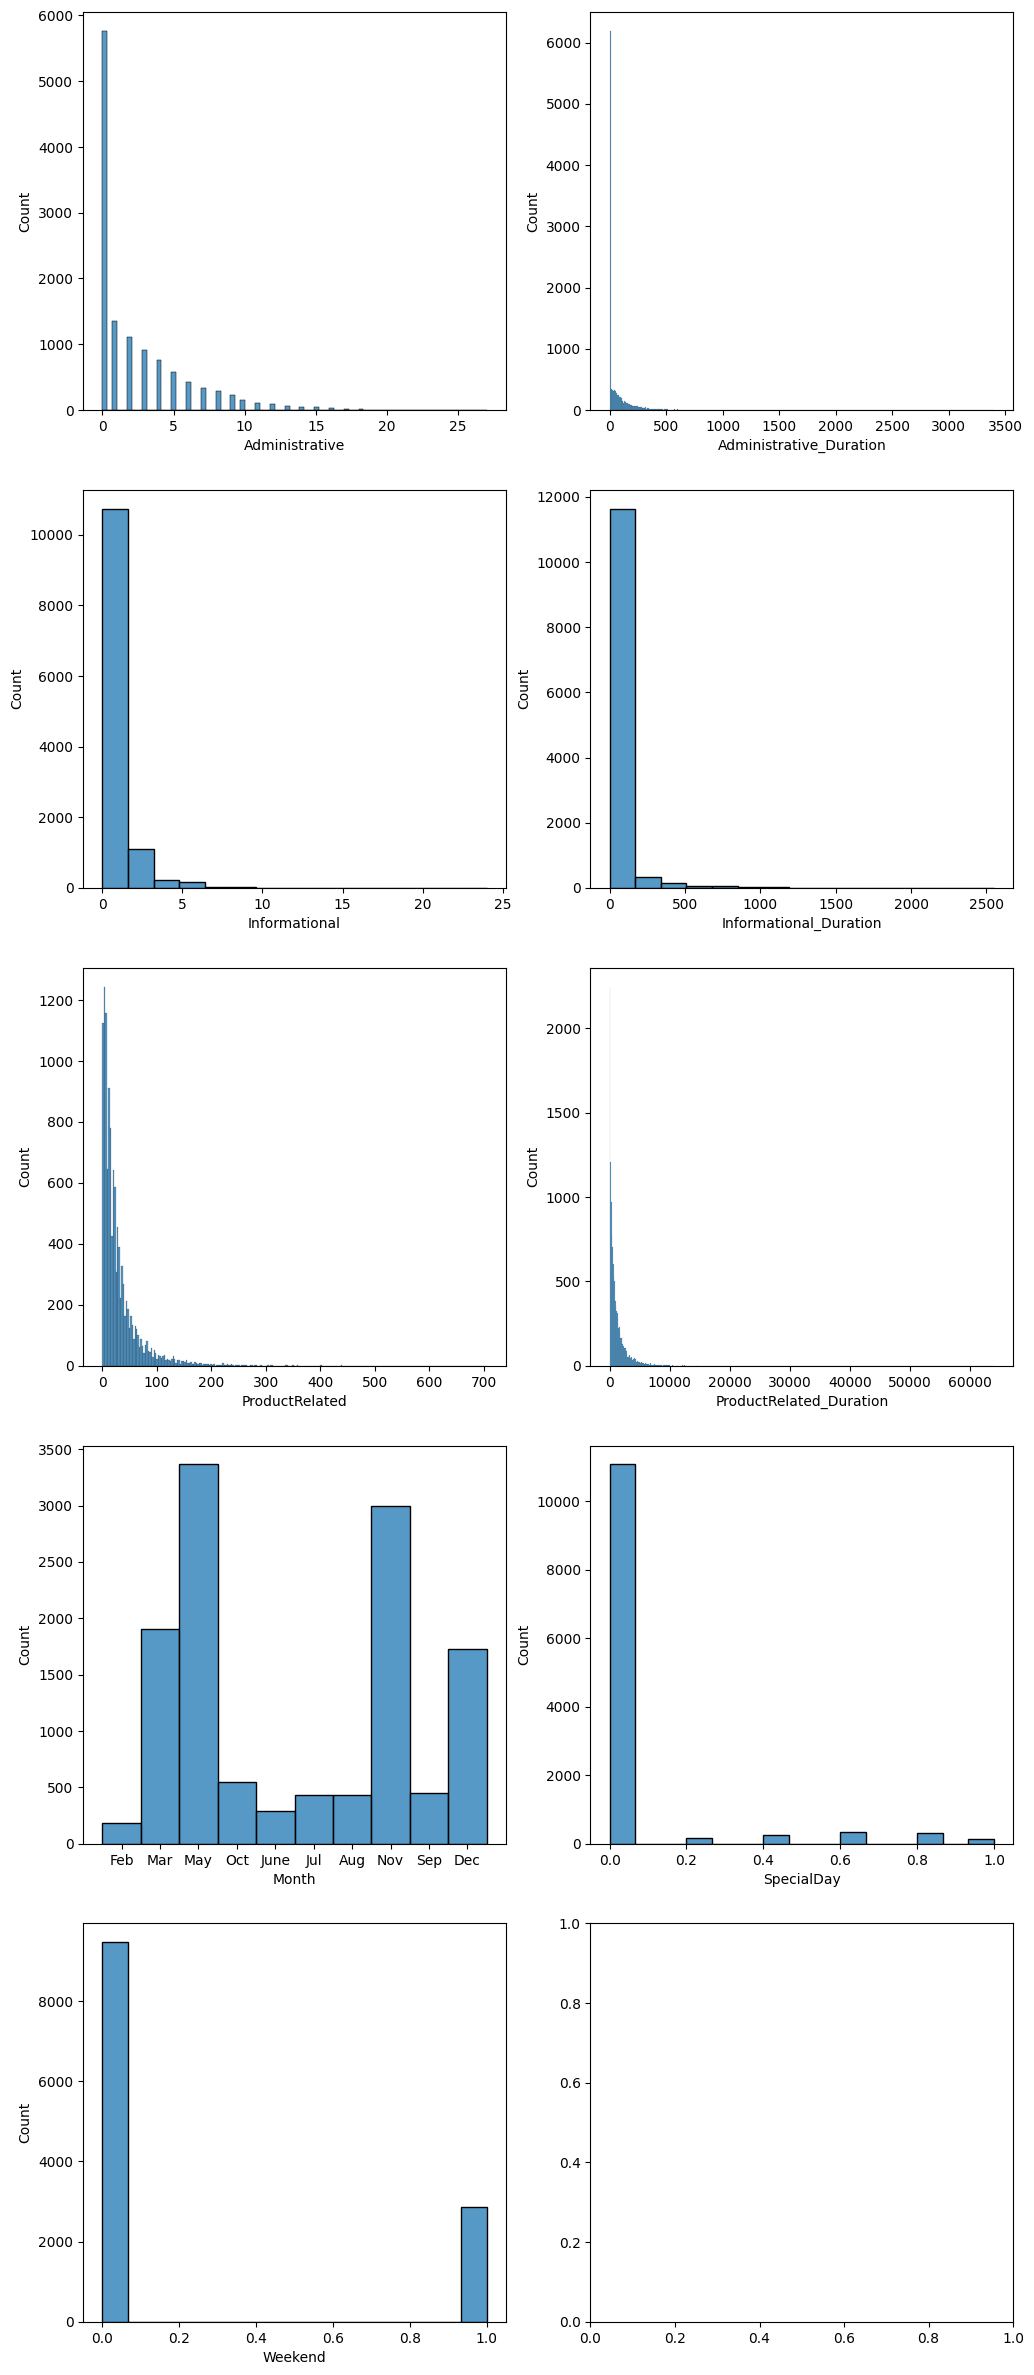

In [64]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(12, 30))
variaveis = ['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
        'Month', 'SpecialDay', 'Weekend']
for i, var in enumerate(variaveis):
    sns.histplot(ax=axes[i//2][i%2], x=df[var])

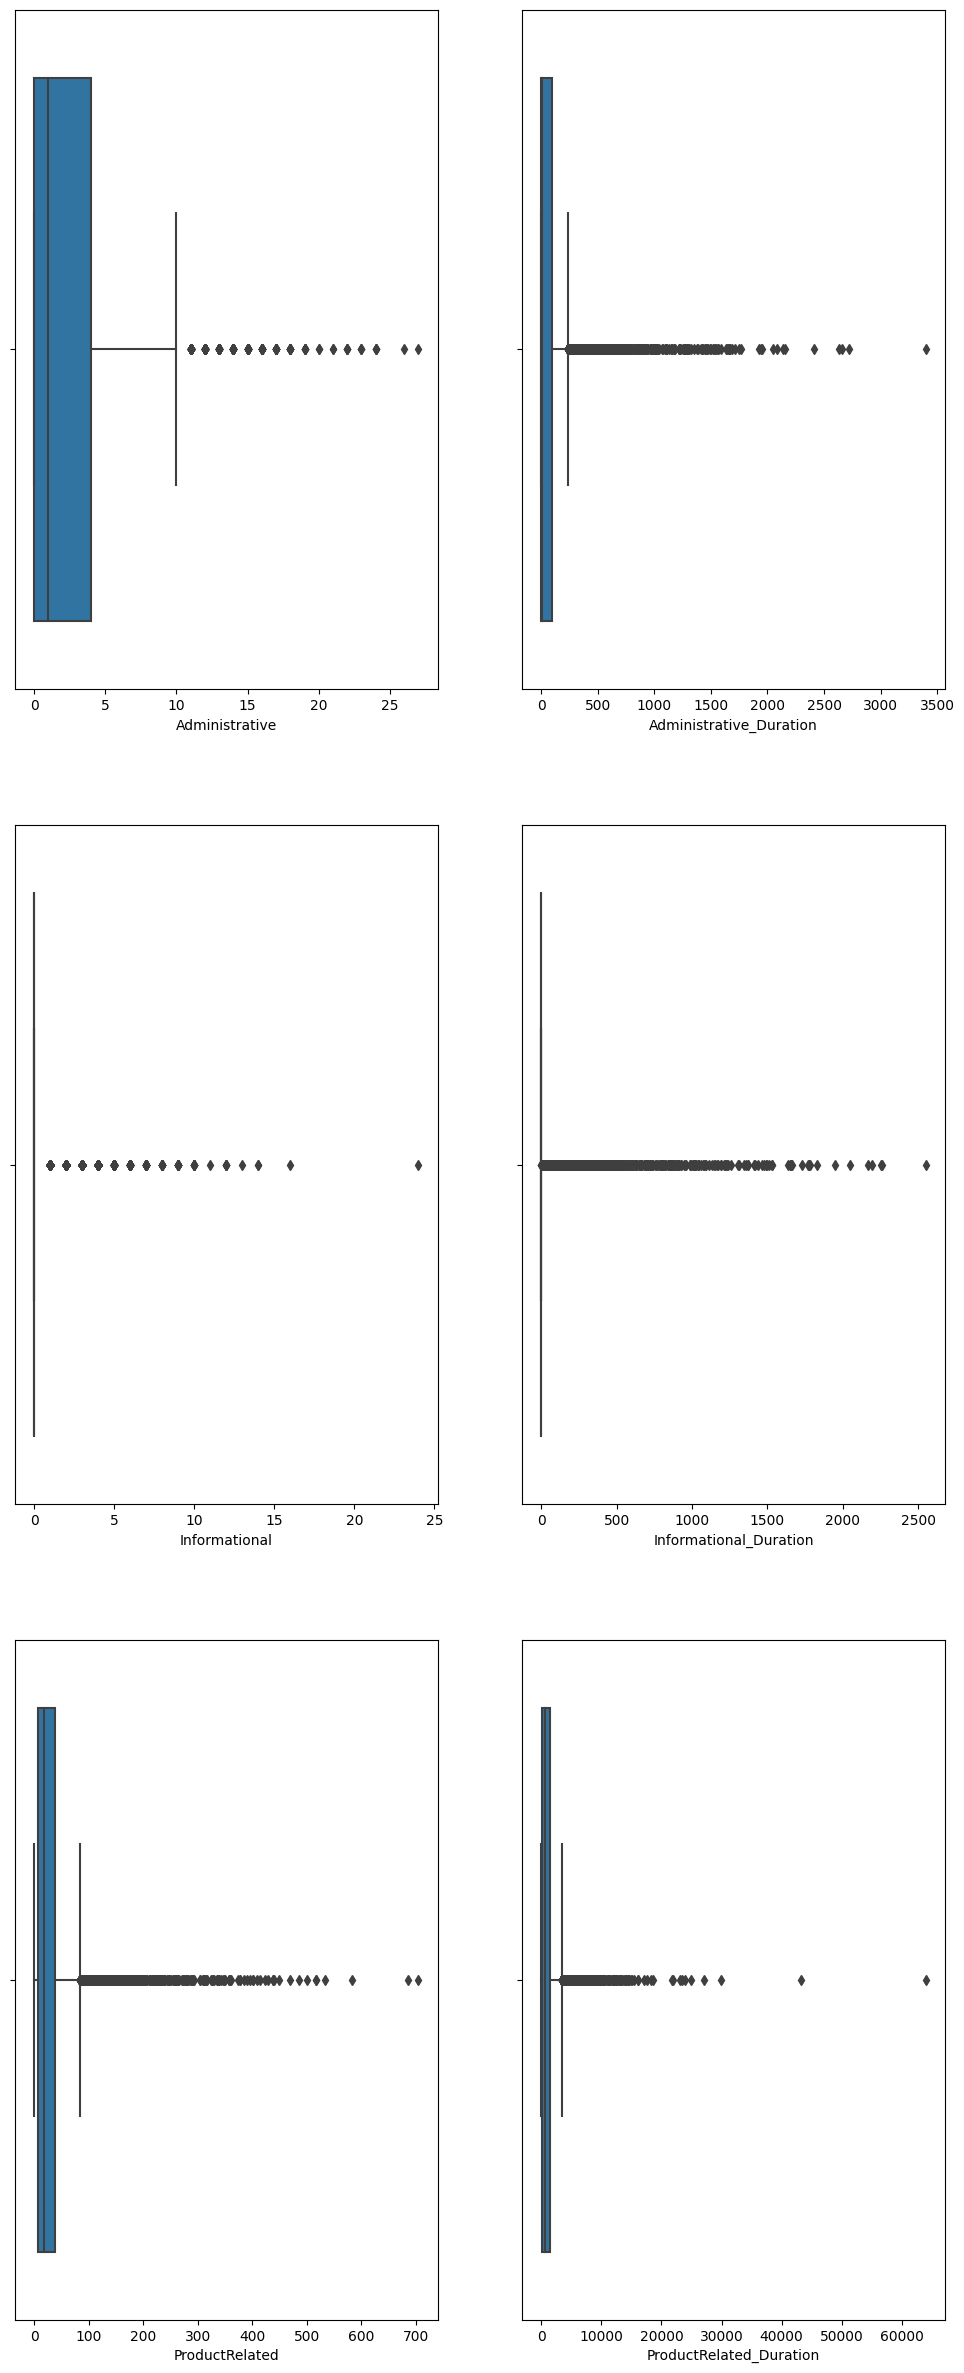

In [65]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 16))

for i, var in enumerate(variaveis[:6]):
    sns.boxplot(ax=axes[i//2][i%2], x=df[var])

In [70]:
for var in variaveis[:6]:
    q1 = df[var].quantile(q=0.25)
    q3 = df[var].quantile(q=0.75)
    iqr = q3 - q1
    outliers_cut = q3 + (1.5 * iqr)
    print(var, outliers_cut, q3)
    print(df.query(f"{var} > @outliers_cut").shape[0])
    if outliers_cut != 0:
        df[var].mask(df[var] > outliers_cut, q3, inplace=True)


Administrative 10.0 4.0
404
Administrative_Duration 233.14062499999997 93.25625
1172
Informational 0.0 0.0
2631
Informational_Duration 0.0 0.0
2405
ProductRelated 84.5 38.0
987
ProductRelated_Duration 3384.1867837500004 1464.1572135000001
961


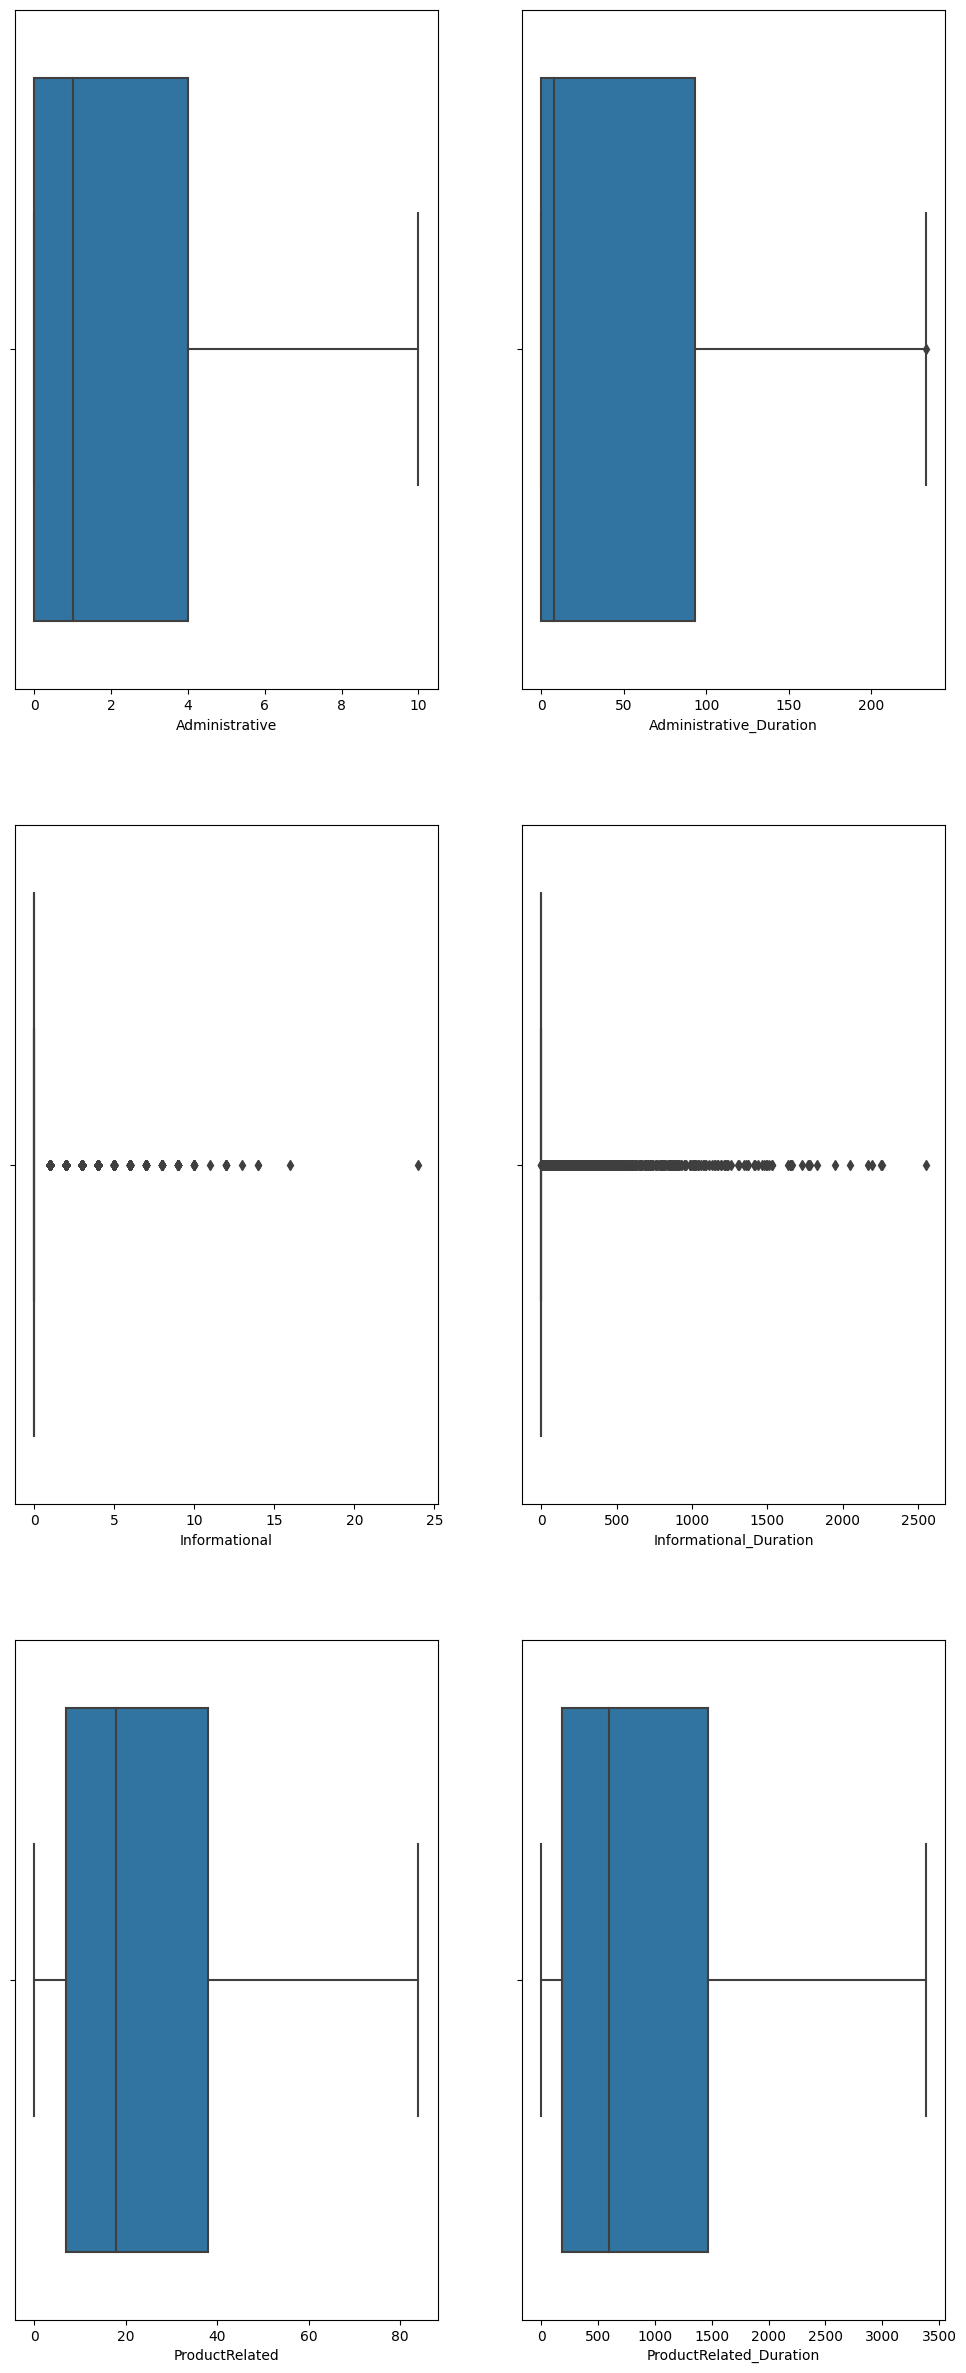

In [72]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 16))

for i, var in enumerate(variaveis[:6]):
    sns.boxplot(ax=axes[i//2][i%2], x=df[var])

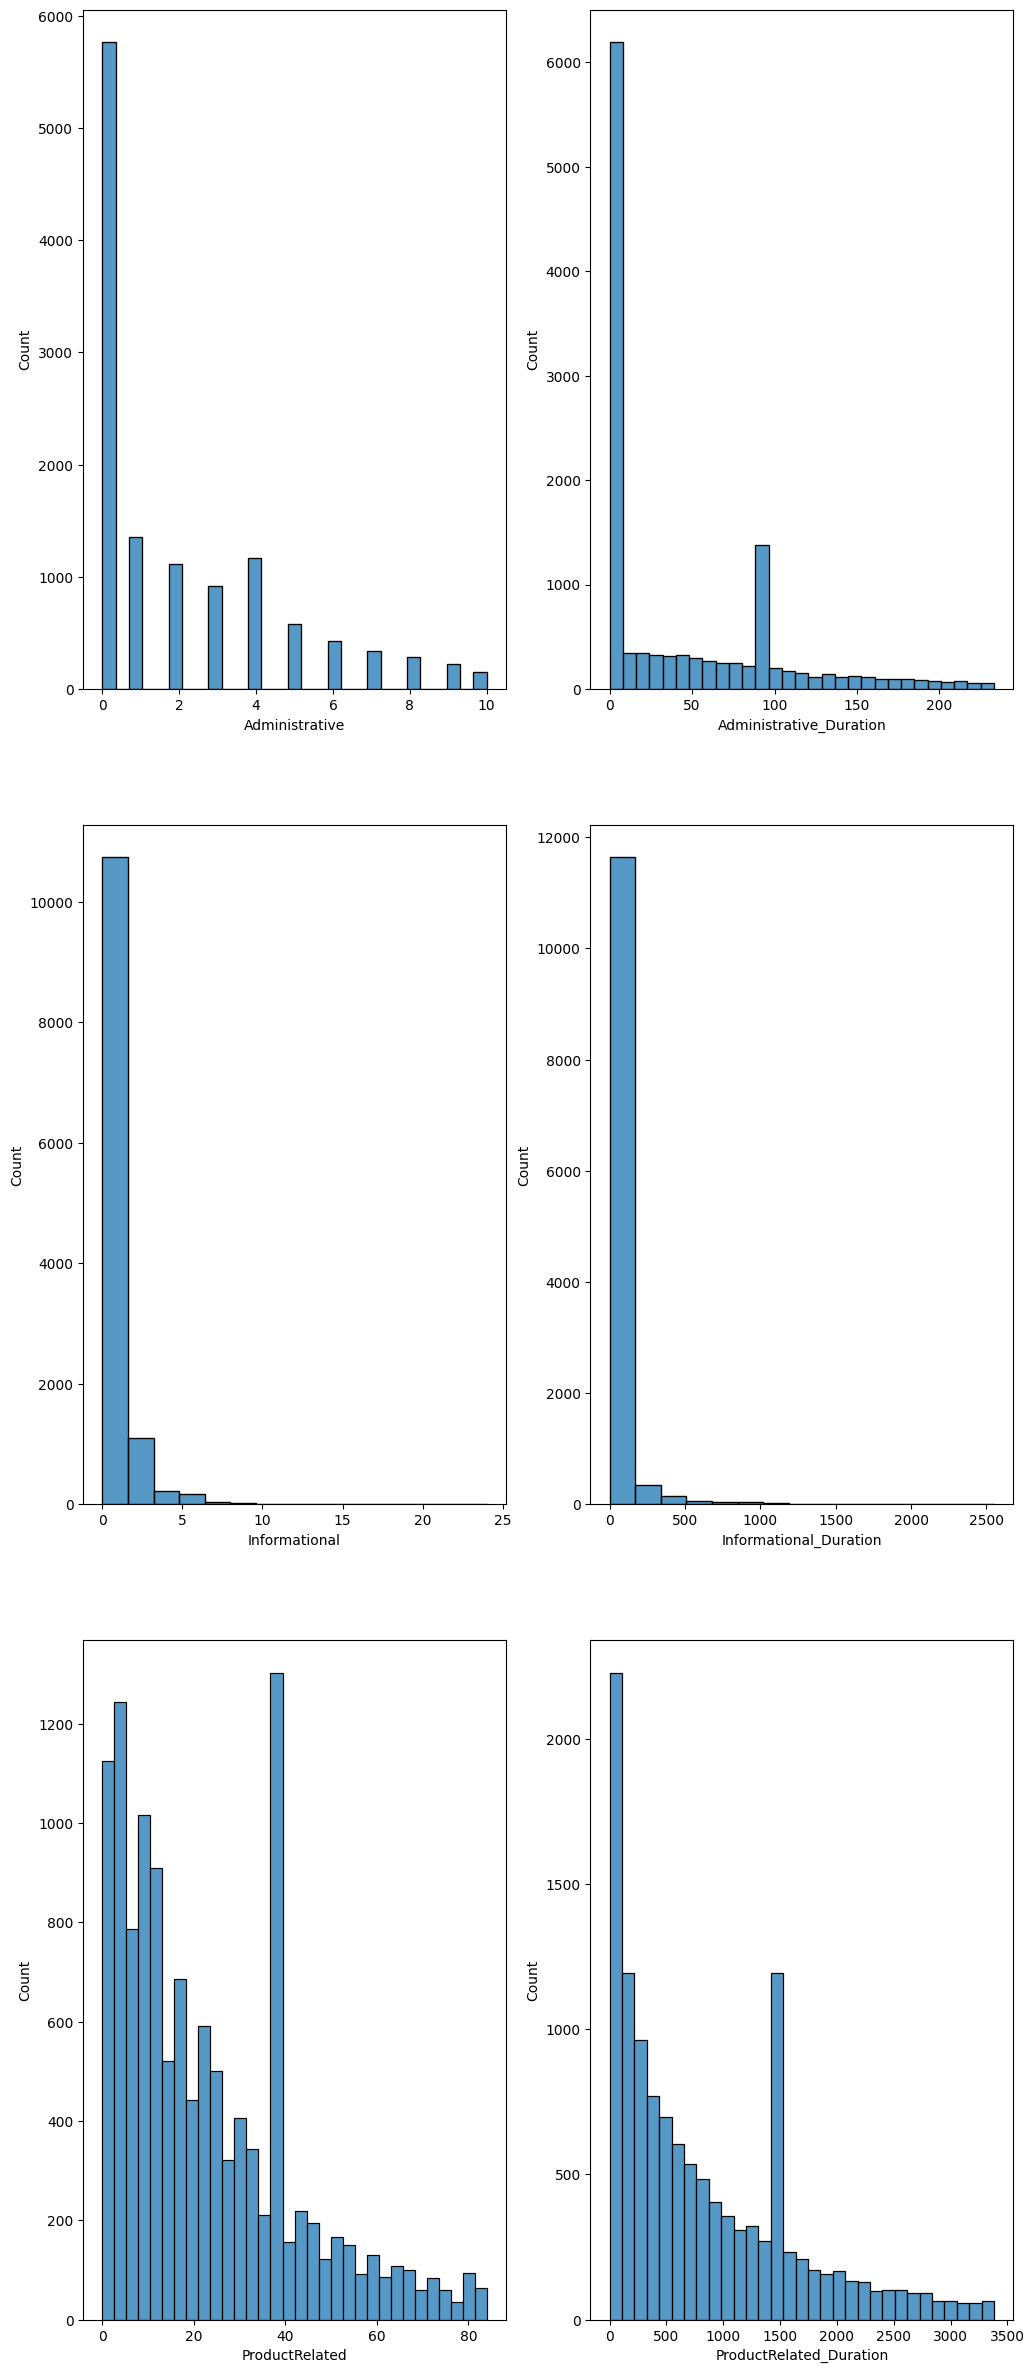

In [71]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 16))

for i, var in enumerate(variaveis[:6]):
    sns.histplot(ax=axes[i//2][i%2], x=df[var])

## Variáveis de agrupamento

Liste as variáveis que você vai querer utilizar. Essa é uma atividade importante do projeto, e tipicamente não a recebemos pronta. Não há resposta pronta ou correta, mas apenas critérios e a sua decisão. Os critérios são os seguintes:

- Selecione para o agrupamento variáveis que descrevam o padrão de navegação na sessão.
- Selecione variáveis que indiquem a característica da data.
- Não se esqueça de que você vai precisar realizar um tratamento especial para variáveis qualitativas.
- Trate adequadamente valores faltantes.

In [73]:
new_df = df[variaveis].copy()

In [74]:
# month_dummies = pd.get_dummies(new_df['Month'], prefix="Month")
# visitor_type_dummies = pd.get_dummies(new_df['VisitorType'], prefix="VisitorType")
new_df = pd.get_dummies(new_df.dropna())
# new_df = new_df.join(visitor_type_dummies)
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   SpecialDay               12330 non-null  float64
 7   Weekend                  12330 non-null  bool   
 8   Month_Aug                12330 non-null  uint8  
 9   Month_Dec                12330 non-null  uint8  
 10  Month_Feb                12330 non-null  uint8  
 11  Month_Jul                12330 non-null  uint8  
 12  Month_June               12330 non-null  uint8  
 13  Month_Mar                12330 non-null  uint8  
 14  Month_May             

In [75]:
vars_cat = new_df.select_dtypes(exclude=["int64", "float64"])
cat_mask = [True if x in vars_cat.columns else False for x in new_df.columns]
cat_mask

[False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True]

In [76]:
num_mask = np.invert(cat_mask)
padronizador = StandardScaler()
df_num = padronizador.fit_transform(new_df.loc[:, num_mask])
df_num = pd.DataFrame(df_num, index=new_df.index, columns=new_df.loc[:, num_mask].columns)

df_cat = new_df.loc[:, cat_mask]

In [77]:
df_num.index.name = 'id'
new_df.index.name = 'id'

merged_df = df_num.merge(df_cat, how='left', on="id")
merged_df

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,SpecialDay,Weekend,Month_Aug,Month_Dec,Month_Feb,Month_Jul,Month_June,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep
id,,,,,,,,,,,,,,,,,,
0,-0.777800,-0.762793,-0.396478,-0.244931,-1.155437,-1.070729,-0.308821,False,0,0,1,0,0,0,0,0,0,0
1,-0.777800,-0.762793,-0.396478,-0.244931,-1.102855,-0.989154,-0.308821,False,0,0,1,0,0,0,0,0,0,0
2,-0.777800,-0.762793,-0.396478,-0.244931,-1.155437,-1.070729,-0.308821,False,0,0,1,0,0,0,0,0,0,0
3,-0.777800,-0.762793,-0.396478,-0.244931,-1.102855,-1.067330,-0.308821,False,0,0,1,0,0,0,0,0,0,0
4,-0.777800,-0.762793,-0.396478,-0.244931,-0.682198,-0.270911,-0.308821,True,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12325,0.387624,1.769581,-0.396478,-0.244931,1.578832,1.202909,-0.308821,True,0,1,0,0,0,0,0,0,0,0
12326,-0.777800,-0.762793,-0.396478,-0.244931,-0.945109,-0.477079,-0.308821,True,0,0,0,0,0,0,0,1,0,0
12327,-0.777800,-0.762793,-0.396478,-0.244931,-0.892527,-0.835882,-0.308821,True,0,0,0,0,0,0,0,1,0,0


## Número de grupos

Nesta atividade vamos adotar uma abordagem bem pragmática e avaliar agrupamentos hierárquicos com 3 e 4 grupos, por estarem bem alinhados com uma expectativa e estratégia do diretor da empresa. 

*Atenção*: Cuidado se quiser fazer o dendrograma, pois com muitas observações ele pode ser mais complicado de fazer, e dependendo de como for o comando, ele pode travar o *kernell* do seu python.

## Avaliação dos grupos

Construa os agrupamentos com a técnica adequada que vimos em aula. Não se esqueça de tratar variáveis qualitativas, padronizar escalas das quantitativas, tratar valores faltantes e utilizar a distância correta.

Faça uma análise descritiva para pelo menos duas soluções de agrupamentos (duas quantidades diferentes de grupos) sugeridas no item anterior, utilizando as variáveis que estão no escopo do agrupamento.
- Com base nesta análise e nas análises anteriores, decida pelo agrupamento final. 
- Se puder, sugira nomes para os grupos.

In [78]:
distancia_gower = gower_matrix(merged_df, cat_features=cat_mask)

In [79]:
distancia_gower[:5, :5]

array([[0.        , 0.0017126 , 0.        , 0.00070518, 0.07181489],
       [0.0017126 , 0.        , 0.0017126 , 0.00100743, 0.0701023 ],
       [0.        , 0.0017126 , 0.        , 0.00070518, 0.07181489],
       [0.00070518, 0.00100743, 0.00070518, 0.        , 0.07110972],
       [0.07181489, 0.0701023 , 0.07181489, 0.07110972, 0.        ]],
      dtype=float32)

In [80]:
gdv = squareform(distancia_gower,force='tovector')

In [81]:
Z = linkage(gdv, method='complete')
Z_df = pd.DataFrame(Z,columns=['id1','id2','dist','n'])
Z_df.head()

,id1,id2,dist,n
0,0.0,2.0,0.0,2.0
1,16.0,12330.0,0.0,3.0
2,6.0,79.0,0.0,2.0
3,24.0,50.0,0.0,2.0
4,91.0,12333.0,0.0,3.0


In [82]:
grupos_3 = fcluster(Z, 3, criterion='maxclust')
grupos_4 = fcluster(Z, 4, criterion='maxclust')

In [83]:
df['3_grupos'] = grupos_3
df['4_grupos'] = grupos_4

In [84]:
df['4_grupos'].value_counts()

2    6875
4    3364
1    1907
3     184
Name: 4_grupos, dtype: int64

<AxesSubplot: xlabel='Administrative_Duration', ylabel='4_grupos'>

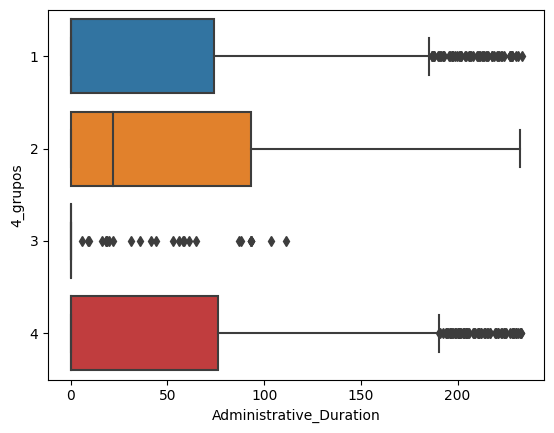

In [110]:
sns.boxplot(data=df, y='4_grupos', x=variaveis[1], orient='h')

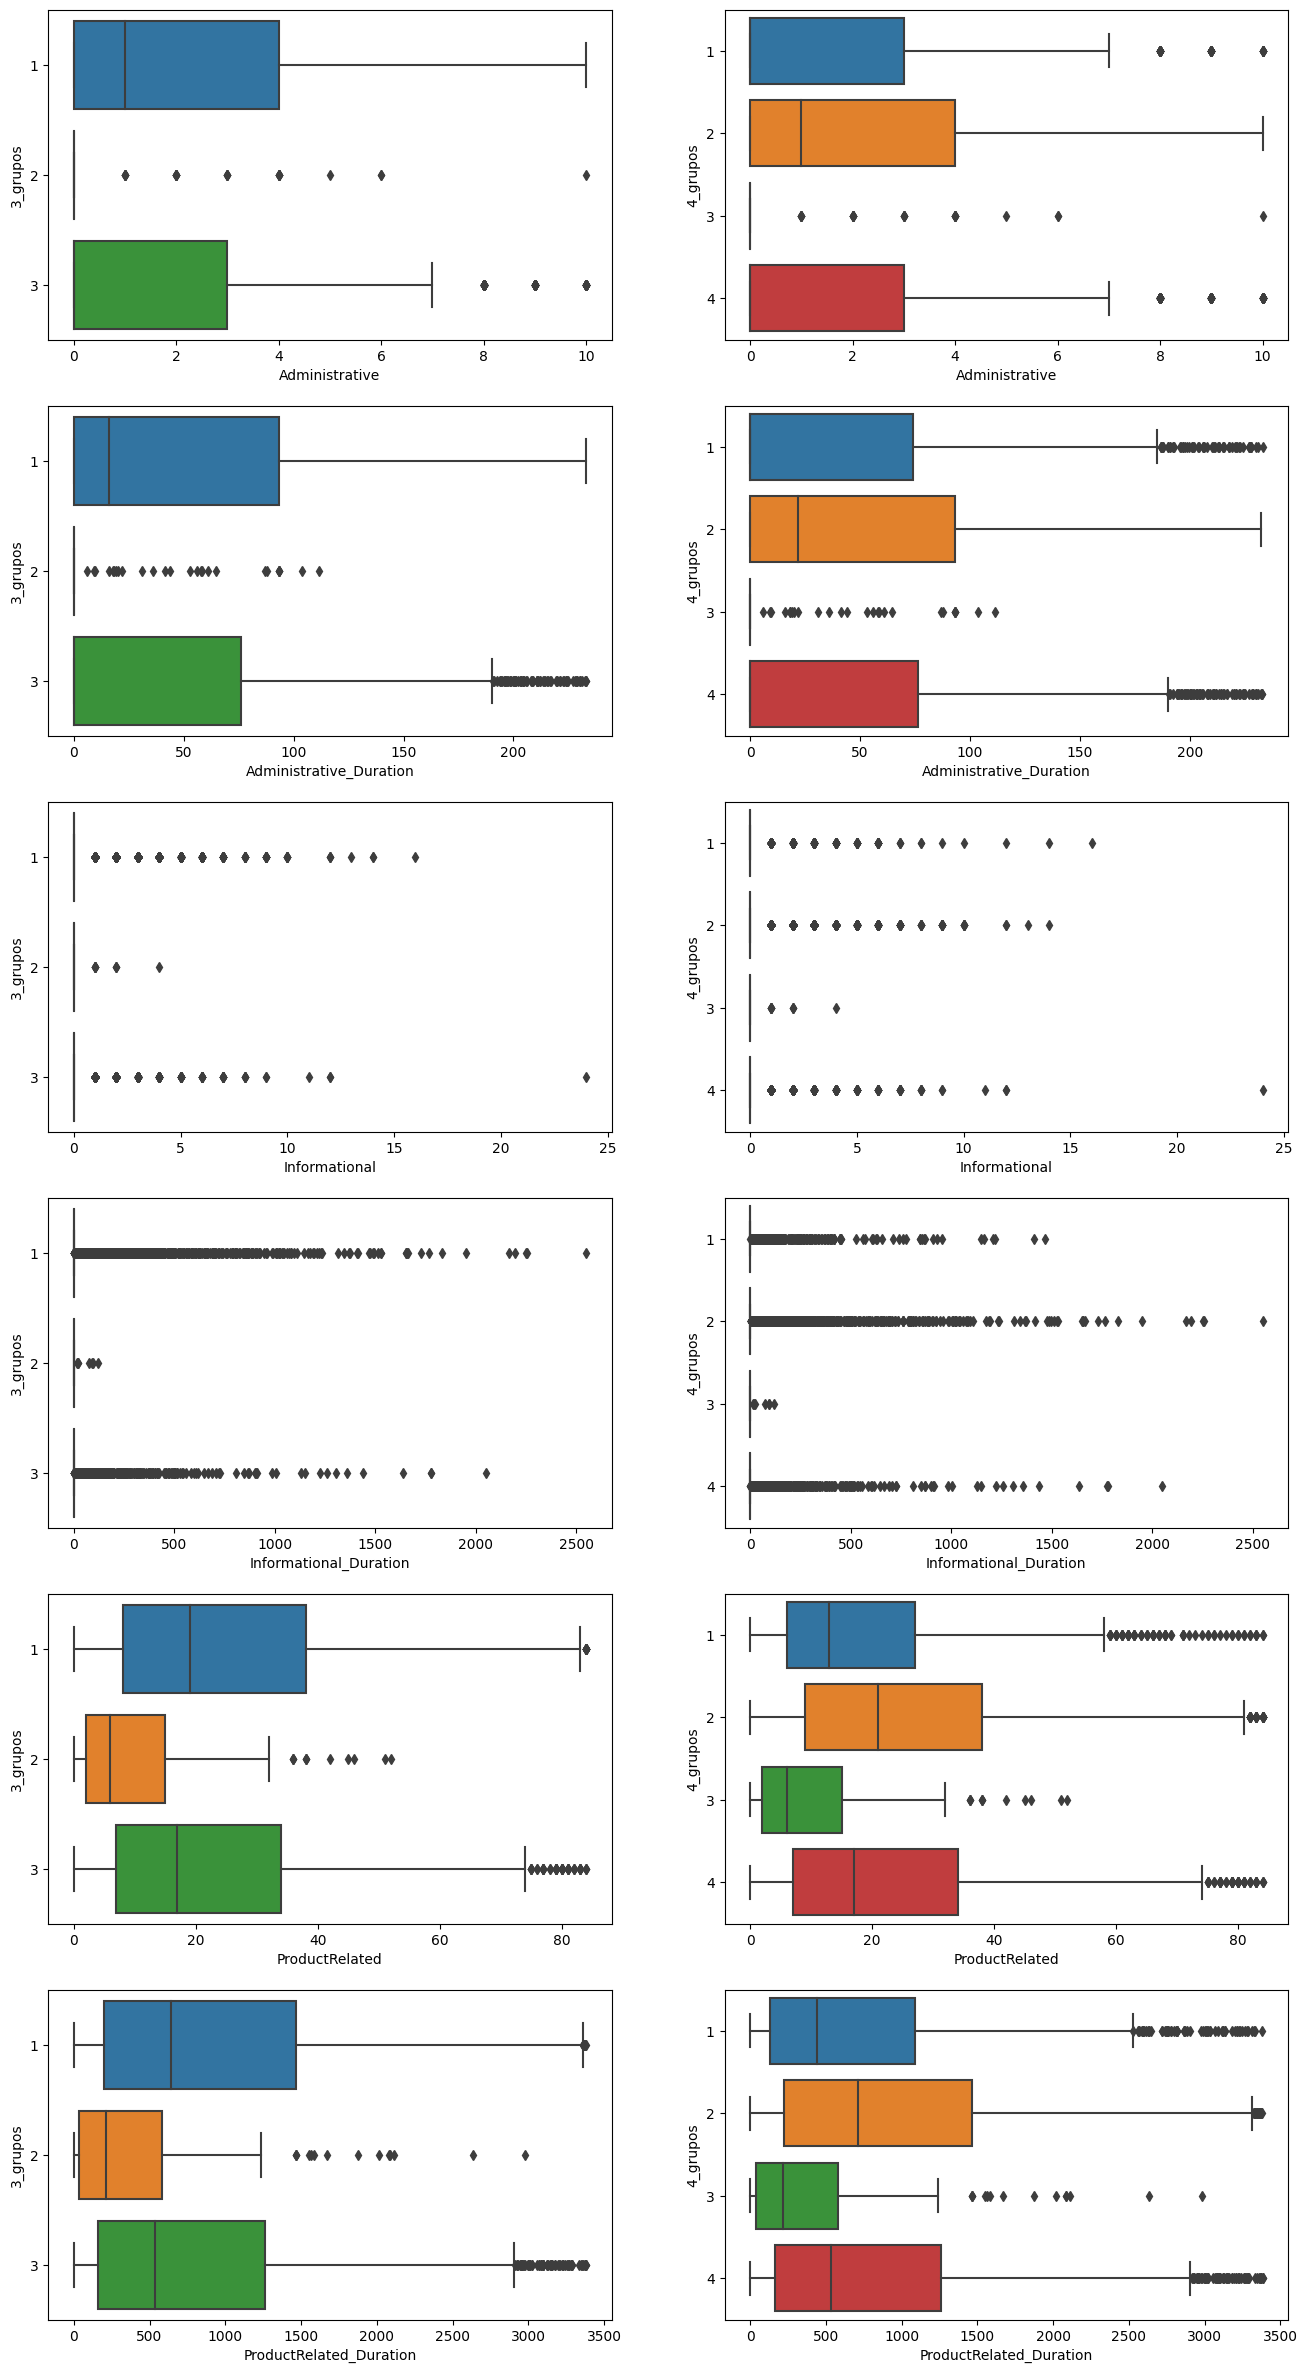

In [113]:
fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(16, 30))
grupos = ["3_grupos", "4_grupos"]
for i in range(12):
    sns.boxplot(data=df, ax=axes[i//2][i%2], y=grupos[i%2], x=variaveis[i//2], orient='h')


<AxesSubplot: xlabel='4_grupos'>

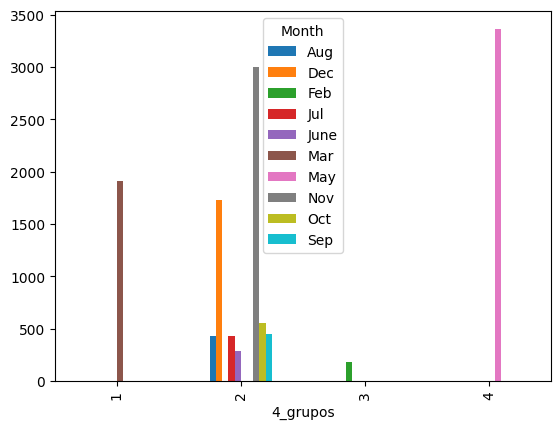

In [188]:
df.groupby(['4_grupos', 'Month'])['Month'].count().unstack().plot.bar()



In [193]:
df.groupby(['4_grupos', 'Weekend'])['Weekend'].count()

4_grupos  Weekend
1         False      1426
          True        481
2         False      5231
          True       1644
3         False       156
          True         28
4         False      2649
          True        715
Name: Weekend, dtype: int64

<AxesSubplot: xlabel='3_grupos'>

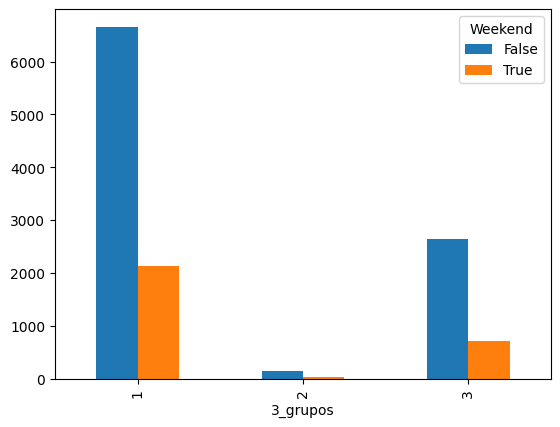

In [186]:
df.groupby(['3_grupos', 'Weekend'])['Weekend'].count().unstack().plot.bar()

<AxesSubplot: xlabel='4_grupos'>

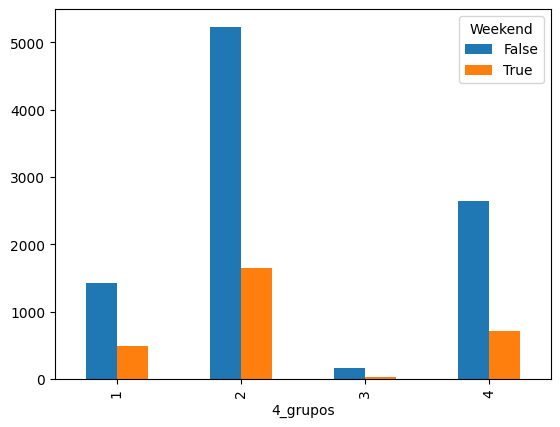

In [187]:
df.groupby(['4_grupos', 'Weekend'])['Weekend'].count().unstack().plot.bar()

**Comentário:** Ao analisar as variáveis quantitativas podemos ver com com 4 grupos o grupo 4 e o grupo 2 ficam parecidos, o que poderia indicar que não vale a pena trabalhar com 4 grupos. Mas ao observarmos o comportamento com as variáveis categóricas, vemos que o grupo 4 e o grupo 2 são diferentes. Portanto, a classificação em 4 grupos parece a melhor opção.

In [91]:
pd.crosstab(df['VisitorType'], df['3_grupos'])

4_grupos,1,2,3,4
VisitorType,,,,
New_Visitor,232,1142,1,319
Other,0,85,0,0
Returning_Visitor,1675,5648,183,3045


In [199]:
pd.crosstab(df['VisitorType'], df['4_grupos'])

4_grupos,1,2,3,4
VisitorType,,,,
New_Visitor,232,1142,1,319
Other,0,85,0,0
Returning_Visitor,1675,5648,183,3045


In [92]:
pd.crosstab(df['Revenue'], df['3_grupos'])

3_grupos,1,2,3
Revenue,,,
False,7242,181,2999
True,1540,3,365


In [93]:
pd.crosstab(df['Revenue'], df['4_grupos'])

4_grupos,1,2,3,4
Revenue,,,,
False,1715,5527,181,2999
True,192,1348,3,365


## Avaliação de resultados

Avalie os grupos obtidos com relação às variáveis fora do escopo da análise (minimamente *bounce rate* e *revenue*). 
- Qual grupo possui clientes mais propensos à compra?

In [238]:
cross_df = pd.crosstab(df['Revenue'], df['3_grupos'])
cross_df.reset_index(inplace=True)
cross_df

3_grupos,Revenue,1,2,3
0,False,7242,181,2999
1,True,1540,3,365


**Comentário:** O grupo 2